### Imports

In [ ]:
!pip install datasets
!pip install spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 109.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook

In [ ]:
import math
import copy
import time
import random
import spacy
import numpy as np
from tqdm.auto import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
from torch.nn.functional import pad
from torch.utils.data import DataLoader

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from datasets import load_dataset
import nltk
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class Vocab:
  def __init__(self, stoi, itos, default_index):
    self.stoi = stoi # mapping from token to index
    self.itos = itos # list of tokens
    self.default_index = default_index # default index for unknown words

  def __getitem__(self, token):
    # Return index of token
    return self.stoi.get(token, self.default_index) # If not found return the default index

  def get_stoi(self):
    return self.stoi

  def lookup_tokens(self, indices):
    # Return the tokens at indices
    return [self.itos[i] for i in indices]

  def __len__(self):
    return len(self.itos)
  def __contains__(self, token):
    return token in self.stoi
  def __iter__(self):
    return iter(self.itos)
  def __repr__(self):
    return f"Vocab({len(self)} tokens)"

In [ ]:
def build_vocab_from_iterator(token_iterator, min_freq, specials):
  counter = Counter() # Use counter to get tokens and frequencies
  for tokens in token_iterator:
      counter.update(tokens)
  tokens = [token for token, freq in counter.items() if freq >= min_freq] # Keep tokens with frequency >= min_freq
  tokens = sorted(tokens) # Sort alphabetically
  itos = list(specials) + tokens
  stoi = {token: idx for idx, token in enumerate(itos)} # token-to-index
  return Vocab(stoi=stoi, itos=itos, default_index=stoi.get("<unk>", 0))

### Word Embeddings Experimentation

In [ ]:
example = "Hello! This is an example of a paragraph that has been split into its basic components. I wonder what will come next! Any guesses?"

def simple_tokenize(sequence):
  # remove punctuation
  for punc in ["!", ".", "?"]:
    sequence = sequence.replace(punc, "")

  # split the sequence on spaces and lowercase each token
  return [token.lower() for token in sequence.split(" ")]

simple_tokenize(example)

['hello',
 'this',
 'is',
 'an',
 'example',
 'of',
 'a',
 'paragraph',
 'that',
 'has',
 'been',
 'split',
 'into',
 'its',
 'basic',
 'components',
 'i',
 'wonder',
 'what',
 'will',
 'come',
 'next',
 'any',
 'guesses']

In [ ]:
def build_vocab(data):
  # tokenize the data and remove duplicates
  vocab = list(set(simple_tokenize(data)))

  # sort the vocabulary
  vocab.sort()

  # assign an integer to each word
  stoi = {word:i for i, word in enumerate(vocab)}

  return stoi

# build the vocab
stoi = build_vocab(example)

stoi

{'a': 0,
 'an': 1,
 'any': 2,
 'basic': 3,
 'been': 4,
 'come': 5,
 'components': 6,
 'example': 7,
 'guesses': 8,
 'has': 9,
 'hello': 10,
 'i': 11,
 'into': 12,
 'is': 13,
 'its': 14,
 'next': 15,
 'of': 16,
 'paragraph': 17,
 'split': 18,
 'that': 19,
 'this': 20,
 'what': 21,
 'will': 22,
 'wonder': 23}

In [ ]:
sequence = [stoi[word] for word in simple_tokenize("I wonder what will come next!")]
sequence

[11, 23, 21, 22, 5, 15]

In [ ]:
vocab_size = len(stoi)

# Embedding dimensions
d_model = 3 # We are using a d_model of 3 to visualize in 3D

# Generate the embedding layer (Usually these would be trained, that's why our current visualization sucks)
embeddings = torch.rand(vocab_size, d_model) # matrix of size (24, 3)
embeddings

tensor([[0.9999, 0.5964, 0.4208],
        [0.4921, 0.7862, 0.4803],
        [0.4247, 0.9864, 0.8181],
        [0.2503, 0.3746, 0.2632],
        [0.8612, 0.0623, 0.2607],
        [0.7360, 0.1850, 0.8144],
        [0.5183, 0.4325, 0.3079],
        [0.4226, 0.1797, 0.7485],
        [0.3200, 0.8843, 0.7033],
        [0.1083, 0.4225, 0.2105],
        [0.7454, 0.6002, 0.0500],
        [0.5531, 0.4199, 0.2143],
        [0.7454, 0.7474, 0.2730],
        [0.8597, 0.2727, 0.9248],
        [0.2772, 0.6449, 0.1313],
        [0.5408, 0.8794, 0.3796],
        [0.0671, 0.6629, 0.3452],
        [0.4586, 0.5107, 0.0096],
        [0.0911, 0.3974, 0.6929],
        [0.9439, 0.4820, 0.3109],
        [0.8405, 0.0344, 0.0399],
        [0.7447, 0.6392, 0.6357],
        [0.4698, 0.2827, 0.4933],
        [0.9534, 0.4255, 0.5280]])

In [ ]:
embedded_sequence = embeddings[sequence]
embedded_sequence

tensor([[0.5531, 0.4199, 0.2143],
        [0.9534, 0.4255, 0.5280],
        [0.7447, 0.6392, 0.6357],
        [0.4698, 0.2827, 0.4933],
        [0.7360, 0.1850, 0.8144],
        [0.5408, 0.8794, 0.3796]])

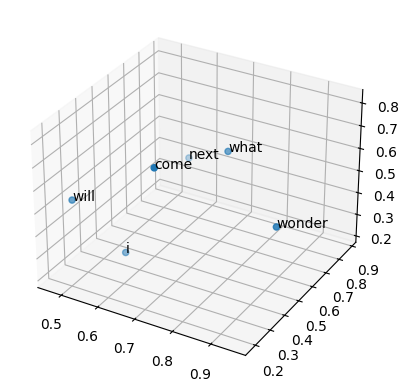

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(embedded_sequence[:, 0], embedded_sequence[:, 1], embedded_sequence[:, 2])

words = [list(stoi.keys())[list(stoi.values()).index(i)] for i in sequence]
for i, word in enumerate(words):
  ax.text(embedded_sequence[i, 0], embedded_sequence[i, 1], embedded_sequence[i, 2], word)

plt.show()

### Helper Functions

In [ ]:
def load_tokenizers():
    try:
        spacy_es = spacy.load("es_core_news_sm")
    except OSError:
        os.system("python -m spacy download es_core_news_sm")
        spacy_es = spacy.load("es_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except OSError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    print("Loaded Spanish and English tokenizers.")
    return spacy_es, spacy_en

def tokenize(text: str, tokenizer):
  return [token.text.lower() for token in tokenizer.tokenizer(text)]

def yield_tokens(data_iter, tokenizer, index: int):
  for from_tuple in data_iter:
    yield tokenizer(from_tuple[index])

In [ ]:
def build_vocabulary(spacy_es, spacy_en, min_freq: int = 2):
    def tokenize_es(text: str):
        return tokenize(text, spacy_es)
    def tokenize_en(text: str):
        return tokenize(text, spacy_en)

    print("Building Spanish Vocabulary...")
    train_es = [ex["translation"]["es"] for ex in load_dataset("opus100", "en-es")["train"]]
    val_es   = [ex["translation"]["es"] for ex in load_dataset("opus100", "en-es")["validation"]]
    test_es  = [ex["translation"]["es"] for ex in load_dataset("opus100", "en-es")["test"]]
    all_es = train_es + val_es + test_es
    # Build spanish vocabulary with tokenized spanish words
    vocab_src = build_vocab_from_iterator((tokenize_es(sentence) for sentence in all_es),
                                                   min_freq=min_freq,
                                                   specials=["<bos>", "<eos>", "<pad>", "<unk>"])

    print("Building English Vocabulary...")
    train_en = [ex["translation"]["en"] for ex in load_dataset("opus100", "en-es")["train"]]
    val_en   = [ex["translation"]["en"] for ex in load_dataset("opus100", "en-es")["validation"]]
    test_en  = [ex["translation"]["en"] for ex in load_dataset("opus100", "en-es")["test"]]
    all_en = train_en + val_en + test_en
    # Build english vocabulary with tokenized english words
    vocab_trg = build_vocab_from_iterator((tokenize_en(sentence) for sentence in all_en),
                                                   min_freq=min_freq,
                                                   specials=["<bos>", "<eos>", "<pad>", "<unk>"])

    print("Finished.\nVocabulary sizes:")
    print("\tSource (Spanish):", len(vocab_src.stoi))
    print("\tTarget (English):", len(vocab_trg.stoi))
    return vocab_src, vocab_trg

def load_vocab(spacy_es, spacy_en, min_freq: int = 2):
  if not os.path.exists("vocab.pt"):
    vocab_src, vocab_trg = build_vocabulary(spacy_es, spacy_en, min_freq)
    torch.save((vocab_src, vocab_trg), "vocab.pt")
  else:
    vocab_src, vocab_trg = torch.load("vocab.pt")

  print("Finished.\nVocabulary sizes:")
  print("\tSource:", len(vocab_src))
  print("\tTarget:", len(vocab_trg))
  return vocab_src, vocab_trg

In [ ]:
import os
import torch

def data_process(raw_data, batch_size=512, cache_file="processed_data.pt"):
    # If processed data exists, load and return it
    if os.path.exists(cache_file):
        print("Loading processed data from cache...")
        data = torch.load(cache_file)
        return data

    data = []
    # Unzip the raw data into separate lists of Spanish and English sentences
    raw_es_list, raw_en_list = zip(*raw_data)

    # Tokenization using spacy.pipe
    tokenized_es = list(tqdm(spacy_es.pipe(raw_es_list, batch_size=batch_size),
                             total=len(raw_es_list),
                             desc="Tokenizing Spanish"))
    tokenized_en = list(tqdm(spacy_en.pipe(raw_en_list, batch_size=batch_size),
                             total=len(raw_en_list),
                             desc="Tokenizing English"))

    for doc_es, doc_en in tqdm(zip(tokenized_es, tokenized_en),
                               total=len(tokenized_es),
                               desc="Processing documents"):
      # Get the indices of each token from the respective vocabulary
      es_indices = [vocab_src[token.text.lower()] for token in doc_es]
      en_indices = [vocab_trg[token.text.lower()] for token in doc_en]
      es_tensor = torch.tensor(es_indices, dtype=torch.long)
      en_tensor = torch.tensor(en_indices, dtype=torch.long)
      data.append((es_tensor, en_tensor))

    # Save the processed data to disk
    torch.save(data, cache_file)
    print("Processed data saved to", cache_file)
    return data

In [ ]:
def generate_batch(data_batch):
  """Process indexed-sequences by adding <bos>, <eos>, and <pad> tokens."""
  es_batch, en_batch = [], []

  for (es_item, en_item) in data_batch:
    # add <bos> and <eos> indices before and after the sentence
    es_temp = torch.cat([torch.tensor([BOS_IDX]), es_item, torch.tensor([EOS_IDX])], dim=0)
    en_temp = torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0)

    # Add padding
    es_batch.append(pad(es_temp,(0, # dimension to pad
                            MAX_PADDING - len(es_temp), # amount of padding to add
                          ),value=PAD_IDX,))

    # Add padding
    en_batch.append(pad(en_temp,(0, # dimension to pad
                            MAX_PADDING - len(en_temp), # amount of padding to add
                          ),
                          value=PAD_IDX,))

  return torch.stack(es_batch), torch.stack(en_batch)

In [ ]:
def display_attention(sentence: list, translation: list, attention: Tensor,
                      n_heads: int = 8, n_rows: int = 4, n_cols: int = 2):
  """
    Display the attention matrix for each head of a sequence.

    Args:
        sentence:     Spanish sentence to be translated to Englis
        translation:  English sentence predicted by the model
        attention:    attention scores for the heads
  """
  assert n_rows * n_cols == n_heads
  fig = plt.figure(figsize=(15,25))

  for i in range(n_heads):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # Select the respective head and make it a numpy array for plotting
    _attention = attention.squeeze(0)[i,:,:].cpu().detach().numpy()
    cax = ax.matshow(_attention, cmap='bone')
    ax.tick_params(labelsize=12)

    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(translation)))

    if isinstance(sentence[0], str):
      ax.set_xticklabels([t.lower() for t in sentence], rotation=45)
      ax.set_yticklabels(translation)
    elif isinstance(sentence[0], int):
      ax.set_xticklabels(sentence)
      ax.set_yticklabels(translation)

  plt.show()

### Transformer Model

In [ ]:
# Embedding Layer
class EmbeddingLayer(nn.Module):
  def __init__(self,
               vocab_size: int,
               d_model: int):
    """
    vocab_size: size of the vocabulary
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    """
    super().__init__()

    self.d_model = d_model

    # Embedding look-up table (vocab_size, d_model)
    self.lut = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

  def forward(self, x):
    # (We multiply by sqrt d_model here, and divide by it again later on in the softmax function in attention)
    return self.lut(x) * math.sqrt(self.d_model) # Scaling factor

**Positional Encoding Equations**

$PE(k, 2i) = sin(\frac{k}{10000^{\frac{2i}{d_{model}}}})$

$PE(k, 2i + 1) = cos(\frac{k}{10000^{\frac{2i}{d_{model}}}})$

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self,
               d_model: int,
               dropout: float = 0.1,
               max_length: int = 5000):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    dropout: probability of dropout
    max_length: max length of a sequence
    """
    super().__init__()

    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_length, d_model) # (max_length, d_model)
    # Create position column
    k = torch.arange(0, max_length).unsqueeze(dim=1)
    # Use the log version of the function for positional encodings
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    # Use sine for the even indices and cosine for the odd indices
    pe[:, 0::2] = torch.sin(k * div_term)
    pe[:, 1::2] = torch.cos(k * div_term)

    pe = pe.unsqueeze(dim=0) # Add the batch dimension

    # We use a buffer because the positional encoding is fixed and not a model paramter that we want to be updated during backpropagation.
    self.register_buffer("pe", pe) # Buffers are saved with the model state and are moved to the correct device

  def forward(self, x):
    # x shape: (batch_size, seq_length, d_model)
    # Add the positional encoding to the embeddings that are passed in
    x += self.pe[:, :x.size(1)]
    return self.dropout(x)

**Multi-Head Self-Attention Equations:**

$Q = X W_q$

$K = X W_k$

$V = X W_v$

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_{key}}})V$

In [ ]:
# Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
  def __init__(self,
               d_model: int = 512,
               n_heads: int = 8,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()
    assert d_model % n_heads == 0 # We want to make sure that the dimensions are split evenly among the attention heads.
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_key = d_model // n_heads

    self.Wq = nn.Linear(d_model, d_model) # Learnable weights for query
    self.Wk = nn.Linear(d_model, d_model) # Learnable weights for key
    self.Wv = nn.Linear(d_model, d_model) # Learnable weights for value
    self.Wo = nn.Linear(d_model, d_model) # Learnable weights for output

    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              query: Tensor,
              key: Tensor,
              value: Tensor,
              mask: Tensor = None):
    """
    query: (batch_size, q_length, d_model)
    key: (batch_size, k_length, d_model)
    value: (batch_size, s_length, d_model)
    """
    batch_size = key.size(0)

    # Matrix multiplication for Q, K, and V tensors
    Q = self.Wq(query)
    K = self.Wk(key)
    V = self.Wv(value)

    # Split each tensor into heads
    Q = Q.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, q_length, d_key)
    K = K.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, k_length, d_key)
    V = V.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, v_length, d_key)

    # Scaled dot product
    scaled_dot_product = torch.matmul(Q, K.permute(0, 1, 3, 2) / math.sqrt(self.d_key)) # K^T becomees (batch_size, n_heads, d_key, k_length)

    if mask is not None:
      scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, float('-inf')) # Filling it with 0 would result in 1 after the mask because e^0 = 1. Intead we fill it with an incredibly large negative number

    # Softmax function for attention probabilities
    attention_probs = torch.softmax(scaled_dot_product, dim=-1)

    # Multiply by V to get attention with respect to the values
    A = torch.matmul(self.dropout(attention_probs), V)

    # Reshape attention back to (batch_size, q_length, d_model)
    A = A.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.n_heads * self.d_key)

    # Pass through the final linear layer
    output = self.Wo(A)

    return output, attention_probs

In [ ]:
# Position-Wise Feed Forward Network (FFN)
class PositionwiseFeedForward(nn.Module):
  def __init__(self,
               d_model: int,
               d_ffn: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    self.ffn = nn.Sequential(
        nn.Linear(in_features=d_model, out_features=d_ffn),
        nn.ReLU(),
        nn.Linear(in_features=d_ffn, out_features=d_model),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.ffn(x)

In [ ]:
# Encoder Layer
class EncoderLayer(nn.Module):
  def __init__(self,
               d_model: int,
               n_heads: int,
               d_ffn: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    # Multi-Head Self-Attention sublayer
    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Position-wise Feed-forward Network
    self.position_wise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
    self.ffn_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              src: Tensor,
              src_mask: Tensor):
    """
    src: embedded sequences (batch_size, seq_length, d_model)
    src_mask: mask for the sequences (batch_size, 1, 1, seq_length)
    """
    # Multi-Head Attention

    # The source mask ensures the model ignores these padding positions by assigning them near-zero attention scores.
    _src, attention_probs = self.attention(src, src, src, src_mask) # Q, K, V, mask

    # Residual Addition and Layer Normalization
    src = self.attention_layer_norm(src + self.dropout(_src)) # We do residual addition by adding back the src (the embeddings) to the output of Self-Attention

    # Position-wise Feed-forward Network
    _src = self.position_wise_ffn(src)

    # Residual Addition and Layer Normalization
    src = self.ffn_layer_norm(src + self.dropout(_src))

    return src, attention_probs

In [ ]:
# The Encoder
class Encoder(nn.Module):
  def __init__(self,
               d_model: int,
               n_layers: int,
               n_heads: int,
               d_ffn: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_layers: number of encoder layers in the encoder block
    n_heads: number of self attention heads per sequence
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    # Create n_layers encoders
    self.layers = nn.ModuleList([EncoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)])
    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              src: Tensor,
              src_mask: Tensor):
    """
    src: embedded sequences (batch_size, seq_length, d_model)
    src_mask: mask for the sequences (batch_size, 1, 1, seq_length)
    """

    # Pass the sequences through each encoder layer
    for layer in self.layers:
      src, attention_probs = layer(src, src_mask)

    self.attention_probs = attention_probs

    src += torch.randn_like(src) * 0.001

    return src

In [ ]:
# Decoder Layer
class DecoderLayer(nn.Module):
  def __init__(self,
               d_model: int,
               n_heads: int,
               d_ffn: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    # Masked Multi-Head Self-Attention sublayer
    self.masked_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.masked_attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Multi-Head Self-Attention sublayer
    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Position-wise Feed-forward Network
    self.position_wise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
    self.ffn_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              trg: Tensor,
              src: Tensor,
              trg_mask: Tensor,
              src_mask: Tensor):
    """
    trg: embedded sequences (batch_size, trg_seq_length, d_model)
    src: embedded sequences (batch_size, src_seq_length, d_model)
    trg_mask: mask for the sequences (batch_size, 1, trg_seq_length, trg_seq_length)
    src_mask: mask for the sequences (batch_size, 1, 1, src_seq_length)
    """

    # Masked Multi-Head Attention

    # The target mask is used to prevent the model from seeing future tokens. This ensures that the prediction is made solely based on past and present tokens.
    _trg, masked_attention_probs = self.masked_attention(trg, trg, trg, trg_mask) # Q, K, V, mask
    # Residual Addition and Layer Normalization
    trg = self.masked_attention_layer_norm(trg + self.dropout(_trg))

    # Multi-Head Attention - This time, we also pass in the output of the encoder layers as src.
    # This is important because this allows us to keep track of and learn relationships between the input and output tokens.
    _trg, attention_probs = self.attention(trg, src, src, src_mask) # Q, K, V, mask
    # Residual Addition and Layer Normalization
    trg = self.attention_layer_norm(trg + self.dropout(_trg))

    # Position-wise Feed-forward Network
    _trg = self.position_wise_ffn(trg)
    # Residual Addition and Layer Normalization
    trg = self.ffn_layer_norm(trg + self.dropout(_trg))

    return trg, attention_probs, masked_attention_probs

In [ ]:
# The Decoder
class Decoder(nn.Module):
  def __init__(self,
               vocab_size: int,
               d_model: int,
               n_layers: int,
               n_heads: int,
               d_ffn: int,
               dropout: float = 0.1):
    """
    vocab_size: size of the target vocabulary
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_layers: number of encoder layers in the encoder block
    n_heads: number of self attention heads per sequence
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    # Create n_layers decoders
    self.layers = nn.ModuleList([DecoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)])
    self.dropout = nn.Dropout(p=dropout)

    # Output layer
    self.Wo = nn.Linear(in_features=d_model, out_features=vocab_size)

  def forward(self,
              trg: Tensor,
              src: Tensor,
              trg_mask: Tensor,
              src_mask: Tensor):
    """
    trg: embedded sequences (batch_size, trg_seq_length, d_model)
    src: embedded sequences (batch_size, src_seq_length, d_model)
    trg_mask: mask for the sequences (batch_size, 1, trg_seq_length, trg_seq_length)
    src_mask: mask for the sequences (batch_size, 1, 1, src_seq_length)
    """

    # Pass the sequences through each decoder layer
    for layer in self.layers:
      trg, attention_probs, masked_attention_probs = layer(trg, src, trg_mask, src_mask)

    self.attention_probs = attention_probs
    self.masked_attention_probs = masked_attention_probs

    trg += torch.randn_like(trg) * 0.001

    return self.Wo(trg)

In [ ]:
# The Transformer
class Transformer(nn.Module):
  def __init__(self,
               encoder: Encoder,
               decoder: Decoder,
               src_embed: EmbeddingLayer,
               trg_embed: EmbeddingLayer,
               src_pad_idx: int,
               trg_pad_idx: int,
               device):
    """
    encoder: encoder stack
    decoder: decoder stack
    src_embed: source embeddings
    trg_embd: target embeddings
    src_pad_idx: source padding index
    trg_pad_idx: target padding index
    device: device
    """
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.device = device
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx

  def make_src_mask(self, src: Tensor):
    # Assign 1 to tokens that need attended to and 0 to padding tokens, then add 2 dimensions
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    return src_mask

  def make_trg_mask(self, trg: Tensor):
    seq_length = trg.shape[1]

    # Assign True to tokens that need attended to and False to padding tokens, then add 2 dimensions
    trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_length)

    # Generate subsequent mask
    trg_sub_mask = torch.tril(torch.ones((seq_length, seq_length), device=self.device)).bool() # (batch_size, 1, seq_length, seq_length)

    # Bottom triangle is True, top triangle is False
    trg_mask = trg_mask & trg_sub_mask

    return trg_mask

  def forward(self, src: Tensor, trg: Tensor):
    """
    trg: raw target sequences (batch_size, trg_seq_length)
    src: raw src sequences (batch_size, src_seq_length)
    """

    # Create source and target masks
    src_mask = self.make_src_mask(src) # (batch_size, 1, 1, src_seq_length)

    # The lower triangle of the mask is filled with 1s
    trg_mask = self.make_trg_mask(trg) # (batch_size, 1, trg_seq_length, trg_seq_length)

    # Encoder layers
    src = self.encoder(self.src_embed(src), src_mask)  # (batch_size, src_seq_length, d_model)

    # Decoder layers
    output = self.decoder(self.trg_embed(trg), src, trg_mask, src_mask) # Pass in both the target (for Masked Multi-Head Self-Attention) and source for (Cross-Attention)

    return output

In [ ]:
def make_model(device,
               src_vocab,
               trg_vocab,
               n_layers: int = 3,
               d_model: int = 512,
               d_ffn: int = 2048,
               n_heads: int = 8,
               dropout: float = 0.1,
               max_length: int = 5000):
  """
  src_vocab: source vocabulary
  trg_vocab: target vocabulary
  n_layers: number of encoder layers in the encoder block
  d_model: dimensions of the embeddings (number of values in each embedding vector)
  d_ffn: dimensions of the feed-forward network
  n_heads: number of self attention heads per sequence
  dropout: probability of dropout
  max_length: maximum sequence length for positional encodings
  """

  encoder = Encoder(d_model=d_model,
                    n_layers=n_layers,
                    n_heads=n_heads,
                    d_ffn=d_ffn,
                    dropout=dropout)

  decoder = Decoder(vocab_size=len(trg_vocab),
                    d_model=d_model,
                    n_layers=n_layers,
                    n_heads=n_heads,
                    d_ffn=d_ffn,
                    dropout=dropout)

  # Create source and target embedding matrices
  src_embed = EmbeddingLayer(vocab_size=len(src_vocab), d_model=d_model)
  trg_embed = EmbeddingLayer(vocab_size=len(trg_vocab), d_model=d_model)

  # Create the positional encoding matrix
  pos_enc = PositionalEncoding(d_model=d_model,
                               dropout=dropout,
                               max_length=max_length)

  # Create the Transformer model
  model = Transformer(encoder=encoder,
                      decoder=decoder,
                      src_embed=nn.Sequential(src_embed, pos_enc),
                      trg_embed=nn.Sequential(trg_embed, pos_enc),
                      src_pad_idx=src_vocab.get_stoi()["<pad>"],
                      trg_pad_idx=trg_vocab.get_stoi()["<pad>"],
                      device=device)

  # Initialize parameters with Xaviar/Glorot
  # This maintains a consistent variance of activations throughout the network
  # Helps avoid issues like vanishing or exploding gradients.
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return model

### Loading and Preprocessing Data

In [ ]:
spacy_es, spacy_en = load_tokenizers()
# Create the spanish and english vocabularies
vocab_src, vocab_trg = load_vocab(spacy_es, spacy_en)

BOS_IDX = vocab_trg['<bos>']
EOS_IDX = vocab_trg['<eos>']
PAD_IDX = vocab_trg['<pad>']

Loaded Spanish and English tokenizers.
Building Spanish Vocabulary...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/237k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/238k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Building English Vocabulary...
Finished.
Vocabulary sizes:
	Source (Spanish): 118759
	Target (English): 86004
Finished.
Vocabulary sizes:
	Source: 118759
	Target: 86004


In [ ]:
raw_datasets = load_dataset("opus100", "en-es")
# Src: Spanish, Trg: English
train_data_raw = [(ex["translation"]["es"], ex["translation"]["en"]) for ex in raw_datasets["train"]]
val_data_raw   = [(ex["translation"]["es"], ex["translation"]["en"]) for ex in raw_datasets["validation"]]
test_data_raw  = [(ex["translation"]["es"], ex["translation"]["en"]) for ex in raw_datasets["test"]]

In [ ]:
len(train_data_raw), len(val_data_raw), len(test_data_raw)

(1000000, 2000, 2000)

In [ ]:
# Process the data by tokenizing and returning word indicies
train_data = data_process(raw_data=train_data_raw, cache_file="processed_train_data.pt")
val_data = data_process(raw_data=val_data_raw, cache_file="processed_val_data.pt")
test_data = data_process(raw_data=test_data_raw, cache_file="processed_test_data.pt")

Loading processed data from cache...


<ipython-input-14-0d56199b4d64>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_file)


Loading processed data from cache...
Loading processed data from cache...


In [ ]:
MAX_PADDING = 20
BATCH_SIZE = 512

train_iter = DataLoader(train_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True,
                        collate_fn=generate_batch,
                        num_workers=0,
                        pin_memory=True)

valid_iter = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True,
                        collate_fn=generate_batch,
                        num_workers=0,
                        pin_memory=True)

test_iter = DataLoader(test_data,
                       batch_size=BATCH_SIZE,
                       shuffle=True,
                       drop_last=True,
                       collate_fn=generate_batch,
                       num_workers=0,
                       pin_memory=True)

### Model Training

In [ ]:
model = make_model(device=device,
                   src_vocab=vocab_src,
                   trg_vocab=vocab_trg,
                   n_layers=3,
                   d_model=512,
                   d_ffn=512,
                   n_heads=8,
                   dropout=0.1,
                   max_length=50)
model.to(device)

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): MultiHeadAttention(
          (Wq): Linear(in_features=512, out_features=512, bias=True)
          (Wk): Linear(in_features=512, out_features=512, bias=True)
          (Wv): Linear(in_features=512, out_features=512, bias=True)
          (Wo): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attention_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (position_wise_ffn): PositionwiseFeedForward(
          (ffn): Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Dropout(p=0.1, inplace=False)
          )
        )
        (ffn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)

In [ ]:
print(f'The model has {(sum(p.numel() for p in model.parameters() if p.requires_grad)):,} trainable parameters')

The model has 161,581,556 trainable parameters


In [ ]:
lr = 0.0005

optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=lr)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # In loss calculation, ignore any target tokens that have an index of PAD_IDX

Let's say that we have a target of: "**[CLS] the big red bus [SEP]**". For simplicity, let’s say that we have a batch size of 1, a sequence length of 6 tokens, a d_model of 192, and 8 attention heads. This means that key and query has a dimension of 24.

Using teacher forcing, the input to the decoder is "[CLS] the big red bus", and the model is trained to predict "the big red bus [SEP]".

We can pass the text through the tokenizer (for this example it will be the BERT tokenizer) to get a sequence of `[101, 11, 57, 234, 89, 102]`, where 101 represents [CLS] and 102 represents [SEP]. This sequence has a shape of **`(batch_size=1, seq_len=6)`**.

**Teacher forcing means that we use the true target value to predict the next token. This has many benefits as in training, we just want to worry about predicting the next word, so this allows us to more accurately calculate the loss and converge on a minimum loss faster.**

After the tokens are passed through the embedding layer and positional encodings are added, they have a shape of `(batch_size=1, seq_len=6, d_model=192)`.

During the decoder layer, we generate a target mask with the lower triangle being set to 1. This should have a shape of `(batch_size=1, n_heads=1, seq_len=6, seq_len=6)`.

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 0 \\1 & 1 & 1 & 0 & 0 \\1 & 1 & 1 & 1 & 0 \\1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
$$

This means that for the first sequence, we want to predict the next word only being given [CLS]. For the second sequence, we want to predict the next word only being given [CLS] the.

During Masked Multi-Head Attention, we first split the d_model into n_heads. This gives us a size of `(batch_size=1, n_heads=8, seq_len=6, d_model=24)`. Next, we compute the scaled dot product between $Q$ and $K^T$. Multiplying Q (batch_size=1, n_heads=8, seq_len=6, d_model=24) and $K^T$ (batch_size=1, n_heads=8, d_model=24, seq_len=6), gives us a shape of `(batch_size=1, n_heads=8, seq_len=6, seq_len=6)`. Each score is also divided by $\sqrt{24}$ to stabilize gradients.

In the target mask, wherever the mask is 0 (indicating future positions), the corresponding score is set to a large negative value (like $- \infty$) so that after softmax the probability becomes zero.

Applying the target mask to the scaled dot product, gives us a matrix with the same size of`(batch_size=1, n_heads=8, seq_len=6, seq_len=6)`, but with the positions that we want to be masked.

This means that for every head, we have 6 sequences each with a sequence length of 6, with each row having an increasing number of tokens that it uses to predict the next word.

The matrix at this point would look something like this for every head:

$$
\begin{bmatrix}
[CLS] & - \infty & - \infty & - \infty & - \infty \\
[CLS] & the & - \infty & - \infty & - \infty \\ [CLS] & the & big & - \infty & - \infty \\ [CLS] & the & big & red & - \infty \\ [CLS] & the & big & red & bus \\
\end{bmatrix}
$$

**(Note that where we have the name of each token is instead just the attention score for that specific token.)**

We can then apply the softmax over the last dimension (the tokens in each row). The positions that have $- \infty$ are set to 0 through the softmax function.

We then multiply the attention scores which have a shape of (batch_size=1, n_heads=8, seq_len=6, seq_len=6) by the V matrix which has a shape of (batch_size=1, n_heads=8, seq_len=6, d_model=24). This results in a weighted sum for each token with a shape of `(batch_size=1, n_heads=8, seq_len=6, d_model=24)`.

When the attention scores are multiplied by the V matrix, at each row of the output matrix of the softmax function, each score is multiplied by a value from the V matrix. This gives us a new matrix, where each row is a 24 dimensional vector that encodes the context for the specific token.

For example, let’s denote the values of the V vector at a certain head as: `[v0, v1, v2, v3, v4, v5]`, where each $v_i$ is 24 dimensions. Let’s say that the attention mechanism produces these values as outputs of the softmax function at a certain token: `[a0 = 0.50, a1 = 0.30, a2 = 0.20, a3 = 0.00, a4 = 0.00, a5 = 0.00]`. This means that at this position, the model is allowed to see only tokens 0, 1, and 2 because of the target mask. The weighted sum for token this token in its head is computed as : $\text{output}[3] = 0.50 \times v0 + 0.30 \times v1 + 0.20 \times v2$

Lastly, we concatenate the heads and permute which gives us a final shape of `(batch_size=1, seq_len=6, d_model=192)`: the same shape as the original.

Although the causal mask prevents each token from seeing “future” tokens, the decoder processes the entire sequence in one forward pass. This means that it computes output representations for all time steps in parallel.

In [ ]:
def train(model,
          iterator,
          optimizer,
          loss_fn,
          clip,
          epoch):
  model.train()
  epoch_loss = 0

  pbar = tqdm(iterator, total=len(iterator), desc=f"Epoch {epoch+1} Progress", colour="#005500")
  for i, (src, trg) in enumerate(pbar):
    src, trg = src.to(device), trg.to(device)

    # Forward pass
    # Pass in the full target sequence without the <eos> token, and in the model we use the target mask to prevent it from peeking at future values
    # We also use this for teacher forcing with the target mask when the target sequence is put over the target mask to get a matrix that represents the different sequences that we use for the trgs. Each new row of the matrix is a sequence with one more word for teacher forcing.
    logits = model(src, trg[:,:-1]) # Remove <eos> token because we want to predict it ourselves

    # Output shape: (batch_size, trg_seq_length - 1, vocab_size) trg_seq_length - 1 is made up of the different teacher-forced sequences

    # Expected target
    expected_output = trg[:,1:] # Remove <bos> token because the <eos> was not generated in the logits, so we need to remove it to properly compare

    # Calculate the loss
    # contiguous() flattens so that every token position in every sequence is treated as an individual prediction.
    loss = loss_fn(logits.contiguous().view(-1, logits.shape[-1]),
                    expected_output.contiguous().view(-1))
    epoch_loss += loss.item()

    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    # Optimizer Step
    optimizer.step()

    pbar.set_postfix(loss=loss.item()) # Update the loss on the tqdm progress bar

  return (epoch_loss / len(iterator))

In [ ]:
def evaluate(model,
             iterator,
             loss_fn):
  model.eval()
  epoch_loss = 0

  with torch.inference_mode():
    for i, (src, trg) in enumerate(iterator):
      src, trg = src.to(device), trg.to(device)

      # Forward pass
      # Pass in the full target sequence without the <eos> token, and in the model we use the target mask to prevent it from peeking at future values
      logits = model(src, trg[:,:-1]) # Remove <eos> token because we want to predict it ourselves

      # expected target
      expected_output = trg[:,1:] # Remove <bos> token because the <eos> was not generated in the logits, so we need to remove it to properly compare

      # Calculate the loss
      # contiguous() flattens so that every token position in every sequence is treated as an individual prediction.
      loss = loss_fn(logits.contiguous().view(-1, logits.shape[-1]),
                      expected_output.contiguous().view(-1))
      epoch_loss += loss.item()

  return (epoch_loss / len(iterator))

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
epochs = 15
clip = 1

best_valid_loss = float('inf')
model_path = "translation_model.pt"

if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print("No saved model found. Starting training...")

    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
      start_time = time.time()

      train_loss = train(model=model,
                        iterator=train_iter,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        clip=clip,
                        epoch=epoch)

      valid_loss = evaluate(model=model,
                            iterator=valid_iter,
                            loss_fn=loss_fn)

      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      message = f"Epoch: {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s"

      # Save the model when it performs better than the previous run
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        message += " --> STORED"

      print(message)
      print(f"Train Loss: {train_loss:.3f} | Train Perplexity: {math.exp(train_loss):7.3f}")
      print(f"Validation Loss: {valid_loss:.3f} |  Validation Perplexity: {math.exp(valid_loss):7.3f}'")

No saved model found. Starting training...


Training progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 1 | Time: 9m 2s --> STORED
Train Loss: 5.415 | Train Perplexity: 224.728
Validation Loss: 5.334 |  Validation Perplexity: 207.200'


Epoch 2 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 2 | Time: 9m 1s --> STORED
Train Loss: 4.230 | Train Perplexity:  68.740
Validation Loss: 4.101 |  Validation Perplexity:  60.378'


Epoch 3 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 3 | Time: 9m 1s --> STORED
Train Loss: 3.644 | Train Perplexity:  38.259
Validation Loss: 3.635 |  Validation Perplexity:  37.893'


Epoch 4 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 4 | Time: 9m 1s --> STORED
Train Loss: 3.268 | Train Perplexity:  26.264
Validation Loss: 3.356 |  Validation Perplexity:  28.687'


Epoch 5 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 5 | Time: 9m 1s --> STORED
Train Loss: 2.974 | Train Perplexity:  19.568
Validation Loss: 3.161 |  Validation Perplexity:  23.590'


Epoch 6 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 6 | Time: 9m 1s --> STORED
Train Loss: 2.769 | Train Perplexity:  15.942
Validation Loss: 3.051 |  Validation Perplexity:  21.139'


Epoch 7 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 7 | Time: 9m 1s --> STORED
Train Loss: 2.622 | Train Perplexity:  13.763
Validation Loss: 2.950 |  Validation Perplexity:  19.110'


Epoch 8 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 8 | Time: 9m 0s --> STORED
Train Loss: 2.508 | Train Perplexity:  12.282
Validation Loss: 2.857 |  Validation Perplexity:  17.412'


Epoch 9 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 9 | Time: 8m 58s --> STORED
Train Loss: 2.409 | Train Perplexity:  11.125
Validation Loss: 2.825 |  Validation Perplexity:  16.855'


Epoch 10 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 10 | Time: 8m 58s --> STORED
Train Loss: 2.332 | Train Perplexity:  10.296
Validation Loss: 2.754 |  Validation Perplexity:  15.711'


Epoch 11 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 11 | Time: 8m 58s
Train Loss: 2.269 | Train Perplexity:   9.665
Validation Loss: 2.818 |  Validation Perplexity:  16.752'


Epoch 12 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 12 | Time: 8m 58s --> STORED
Train Loss: 2.214 | Train Perplexity:   9.155
Validation Loss: 2.704 |  Validation Perplexity:  14.937'


Epoch 13 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 13 | Time: 8m 58s --> STORED
Train Loss: 2.167 | Train Perplexity:   8.730
Validation Loss: 2.685 |  Validation Perplexity:  14.659'


Epoch 14 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 14 | Time: 9m 1s --> STORED
Train Loss: 2.125 | Train Perplexity:   8.376
Validation Loss: 2.678 |  Validation Perplexity:  14.557'


Epoch 15 Progress:   0%|          | 0/1953 [00:00<?, ?it/s]

Epoch: 15 | Time: 8m 58s --> STORED
Train Loss: 2.090 | Train Perplexity:   8.087
Validation Loss: 2.658 |  Validation Perplexity:  14.273'


### Model Evaluation

In [ ]:
test_loss = evaluate(model=model,
                     iterator=test_iter,
                     loss_fn=loss_fn)

print(f'Test Loss: {test_loss:.3f} | Test Perplexity: {math.exp(test_loss):7.3f}')

Test Loss: 2.687 | Test Perplexity:  14.691


In [ ]:
def translate_sentence(sentence, model, device, max_length = 50):
  model.eval()

  # Tokenize the string if it is a string, else just use the list
  if isinstance(sentence, str):
    src = ['<bos>'] + [token.text.lower() for token in spacy_es(sentence)] +  ['<eos>']
  else:
    src = ['<bos>'] + sentence + ['<eos>']

  # Convert to indices
  src_indexes = [vocab_src[token] for token in src]
  src_tensor = torch.tensor(src_indexes).int().unsqueeze(0).to(device)

  # Set the first element of the target indices to the index of the <bos> token for target generation
  trg_indexes = [vocab_trg.stoi['<bos>']]

  # Generate new tokens
  for i in range(max_length):
    trg_tensor = torch.tensor(trg_indexes).int().unsqueeze(0).to(device) # Convert to int and add the batch dim

    # Generate the next token
    with torch.inference_mode():
      logits = model.forward(src_tensor, trg_tensor) # Generate logits for next word using the current target sequence

      # Select the newly predicted token
      pred_token = logits.argmax(2)[:,-1].item()

      # If <eos> token or max length, stop generating
      if pred_token == vocab_trg.get_stoi()['<eos>'] or i == (max_length-1):
        # Decoder input
        trg_input = vocab_trg.lookup_tokens(trg_indexes)

        # Decoder output
        trg_output = vocab_trg.lookup_tokens(logits.argmax(2).squeeze(0).tolist())

        return src, trg_input, trg_output, model.decoder.attention_probs, model.decoder.masked_attention_probs
      else:
        # Add the token to the indices for the next prediction
        trg_indexes.append(pred_token)

In [ ]:
# 'a woman with a large purse is walking by a door'
src_sentence = ['una', 'mujer', 'con', 'un', 'bolso', 'grande', 'pasa', 'por', 'una', 'puerta', '.']

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {trg_output}')

source = ['<bos>', 'una', 'mujer', 'con', 'un', 'bolso', 'grande', 'pasa', 'por', 'una', 'puerta', '.', '<eos>']
target input = ['<bos>', 'a', 'woman', 'with', 'a', 'big', 'bag', 'spends', 'by', 'a', 'door', '.']
target output = ['a', 'woman', 'with', 'a', 'big', 'bag', 'spends', 'by', 'a', 'door', '.', '<eos>']


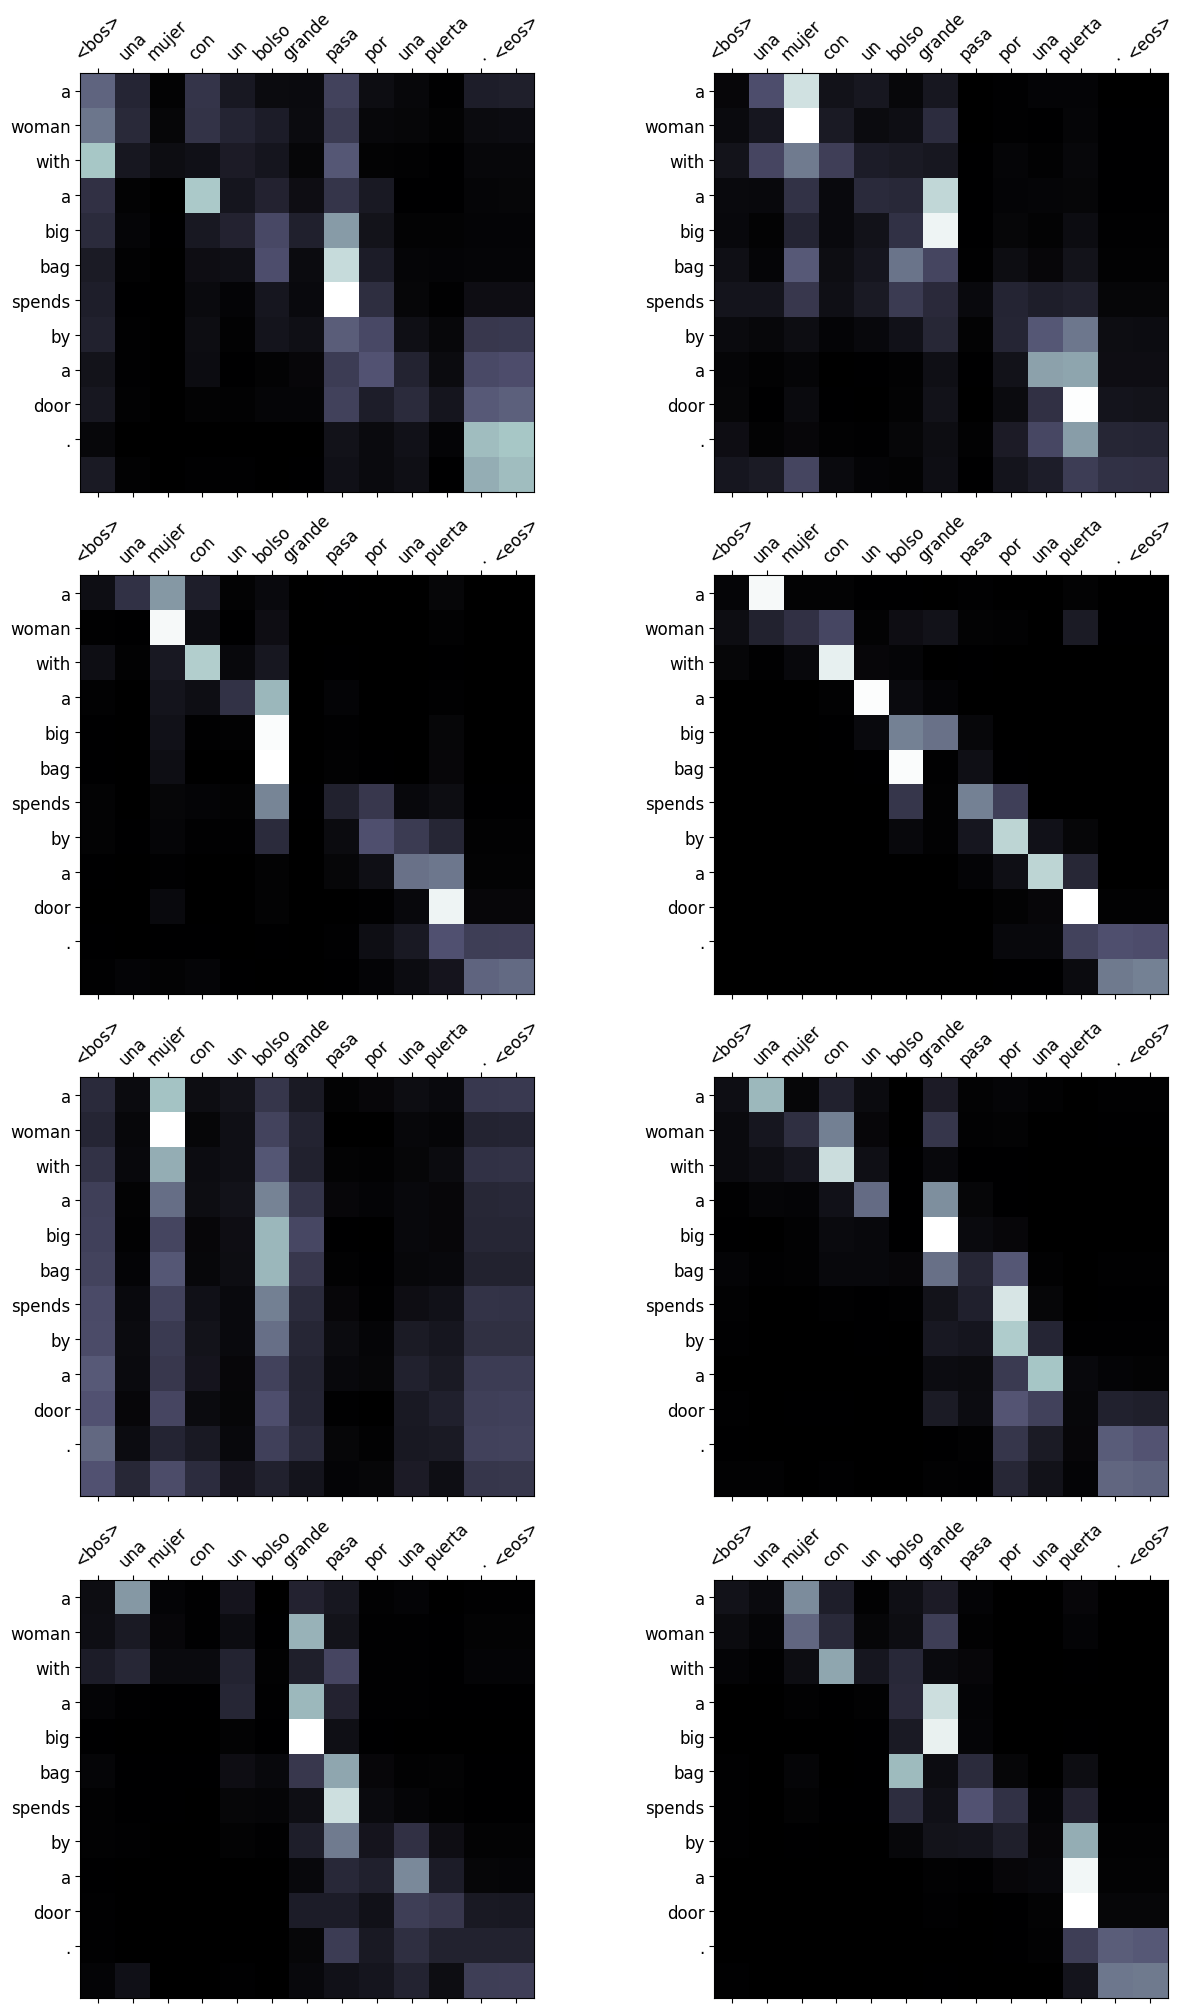

In [ ]:
display_attention(src, trg_input[1:], attention_probs)

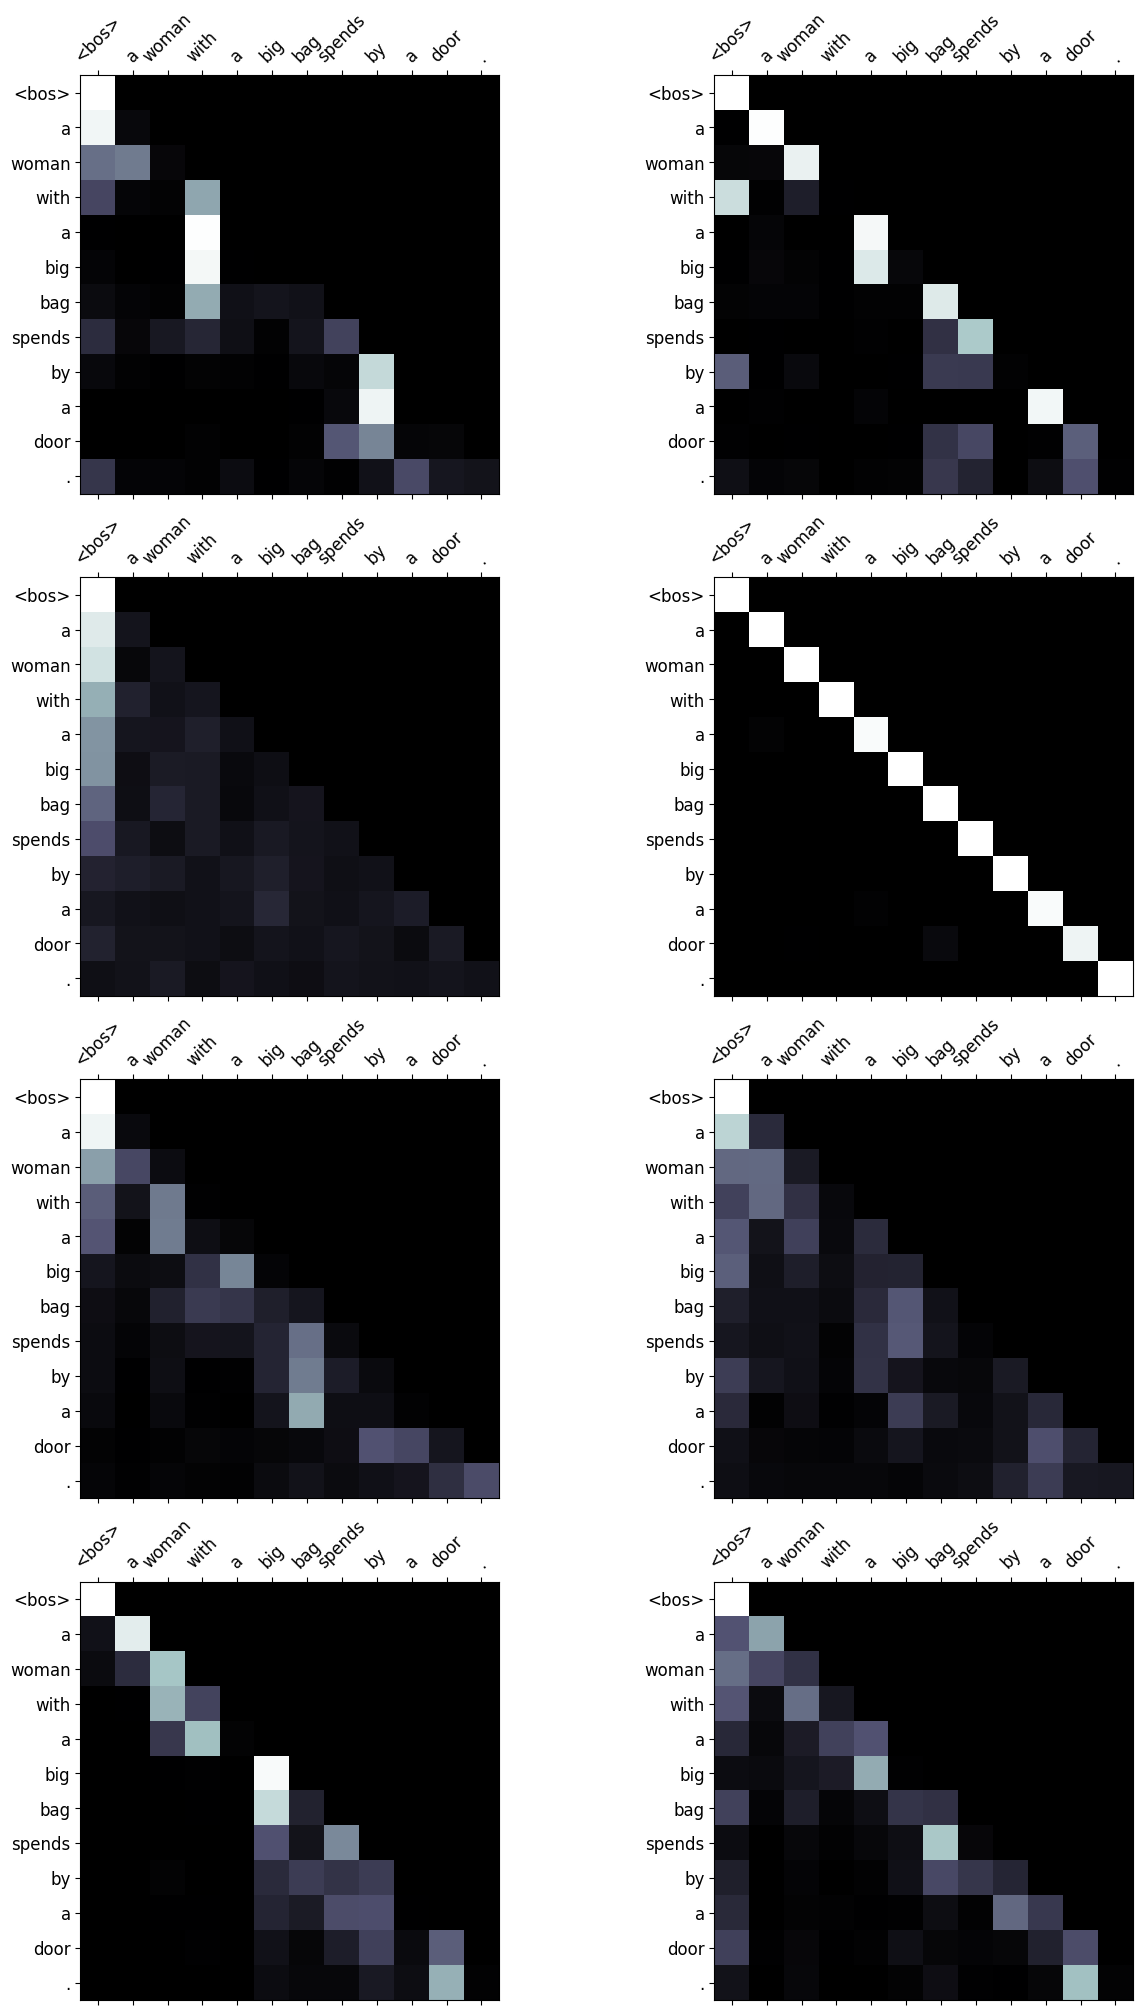

In [ ]:
display_attention(trg_input, trg_input, masked_attention_probs)

In [ ]:
# A boy works in a building
src_sentence = 'Un chico trabaja en un edificio.'

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {trg_output}')

source = ['<bos>', 'un', 'chico', 'trabaja', 'en', 'un', 'edificio', '.', '<eos>']
target input = ['<bos>', 'a', 'kid', 'works', 'in', 'a', 'building', '.']
target output = ['a', 'kid', 'works', 'in', 'a', 'building', '.', '<eos>']


In [ ]:
#  A mother teaches her two young boys to fish off of a rocky coast into very blue water.
src_sentence = 'Una madre enseña a sus dos hijos pequeños a pescar en una costa rocosa en aguas muy azules.'

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {trg_output}')

source = ['<bos>', 'una', 'madre', 'enseña', 'a', 'sus', 'dos', 'hijos', 'pequeños', 'a', 'pescar', 'en', 'una', 'costa', 'rocosa', 'en', 'aguas', 'muy', 'azules', '.', '<eos>']
target input = ['<bos>', 'a', 'mother', 'teaches', 'his', 'two', 'small', 'children', 'to', 'fish', 'in', 'a', 'rocky', 'lake', 'in', 'very', 'blue', '.']
target output = ['a', 'mother', 'teaches', 'his', 'two', 'small', 'children', 'to', 'fish', 'in', 'a', 'rocky', 'lake', 'in', 'very', 'blue', '.', '<eos>']


In [ ]:
src_sentence = 'Hola! Me llamo Rishab. Soy un estudiante. Mi clase favorito en la escuela es la clase de matematicas!'

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {" ".join(trg_output)}')

source = ['<bos>', 'hola', '!', 'me', 'llamo', 'rishab', '.', 'soy', 'un', 'estudiante', '.', 'mi', 'clase', 'favorito', 'en', 'la', 'escuela', 'es', 'la', 'clase', 'de', 'matematicas', '!', '<eos>']
target input = ['<bos>', 'hi', ',', 'i', "'m", 'calling', '<unk>', '.', 'i', "'m", 'a', 'student', '.']
target output = hi , i 'm calling <unk> . i 'm a student . <eos>


In [ ]:
# Did you eat your lunch?
src_sentence = "¿Comiste tu almuerzo?"

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {" ".join(trg_output)}')

source = ['<bos>', '¿', 'comiste', 'tu', 'almuerzo', '?', '<eos>']
target input = ['<bos>', 'did', 'you', 'eat', 'your', 'lunch', '?']
target output = did you eat your lunch ? <eos>


In [ ]:
# My mom is a very hardworking person. I love her so much
src_sentence = "Mi madre es una persona muy trabajadora. La amo mucho."

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {" ".join(trg_output)}')

source = ['<bos>', 'mi', 'madre', 'es', 'una', 'persona', 'muy', 'trabajadora', '.', 'la', 'amo', 'mucho', '.', '<eos>']
target input = ['<bos>', 'my', 'mother', 'is', 'a', 'very', 'person', '.', 'i', 'love', 'her', 'much', '.']
target output = my mother is a very person . i love her much . <eos>


In [ ]:
#@title Spanish-to-English Translator
src_sentence = "¿Vas a ser el orador del panel en el evento de hoy?" #@param ""

src, trg_input, trg_output, attention_probs, masked_attention_probs = translate_sentence(src_sentence, model, device)

print(f'source = {src}')
print(f'target input = {trg_input}')
print(f'target output = {" ".join(trg_output)}')

source = ['<bos>', '¿', 'vas', 'a', 'ser', 'el', 'orador', 'del', 'panel', 'en', 'el', 'evento', 'de', 'hoy', '?', '<eos>']
target input = ['<bos>', 'are', 'you', 'going', 'to', 'be', 'the', 'speaker', "'s", 'speaker', 'today', '?']
target output = are you going to be the speaker 's speaker today ? <eos>
